## Biulding a music genre classifier using HuggingFace pre-trained models

This notebook is based on HuggingFace audio course

In [ ]:
## Needed Libraries


# For Data
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt



#Audio
import librosa
import librosa.display

from IPython.display import Audio



#from IPython.display import Audio

!pip install datasets
from datasets import load_dataset, Audio


# transformers
!pip install git+https://github.com/huggingface/transformers
!pip install -U transformers
!pip install evaluate

#the `Trainer` with `PyTorch` requires `accelerate>=0.21.0`. So we need one the below lines
!pip install -U accelerate
#pip install transformers[torch]



     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 542.0/542.0 kB 9.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 13.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 13.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 16.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 388.9/388.9 kB 26.2 MB/s eta 0:00:00
  Attempting uninstall: huggingface-hub
    Found existing installation: huggingface-hub 0.20.3
    Uninstalling huggingface-hub-0.20.3:
      Successfully uninstalled huggingface-hub-0.20.3
  Cloning https://github.com/huggingface/transformers to /tmp/pip-req-build-ct7li6z4
  Running command git clone --filter=blob:none --quiet https://github.com/huggingface/transformers /tmp/pip-req-build-ct7li6z4
  Resolved https://github.com/huggingface/transformers to commit 78fdd64dcf79dba5f92b88bb297a801028b35515
  Installing build dependencies ... done
  Getting requirements to build whee

In [ ]:
#To get the notebook connected to google drive
from google.colab import drive
drive.mount('/content/drive',force_remount=True)

Mounted at /content/drive


## Loading  Data

In [ ]:
# loading data

from datasets import load_from_disk

data_dir = "/content/drive/MyDrive/Colab Notebooks/Random_GTZAN_2"

# Load the dataset from the disk
loaded_dataset = load_from_disk(data_dir)
songs = loaded_dataset


In [ ]:
songs[0]


{'file': '/content/drive/MyDrive/Colab Notebooks/random_gtzan/blues.00000_part1.wav',
 'audio': {'path': None,
  'array': array([-0.07943726, -0.07846069, -0.08010864, ..., -0.03283691,
         -0.03890991, -0.0413208 ]),
  'sampling_rate': 16000},
 'genre': 0}

In [ ]:
#int2str() method
id2label_fn = songs.features["genre"].int2str
id2label_fn(songs[0]["genre"])

'blues'

In [ ]:
from collections import Counter

genre_counts = Counter(songs['genre'])
print(genre_counts)



Counter({0: 200, 1: 200, 2: 200, 3: 200, 4: 200, 6: 200, 7: 200, 8: 200, 9: 200, 5: 198})


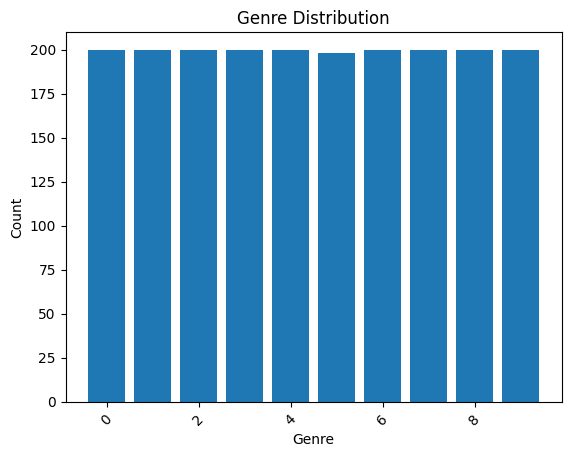

In [ ]:
# plot the labels
import seaborn as sns


# Extracting genre labels and counts
genres = list(genre_counts.keys())
counts = list(genre_counts.values())

# Plotting
plt.bar(genres, counts)
plt.xlabel('Genre')
plt.ylabel('Count')
plt.title('Genre Distribution')
plt.xticks(rotation=45)  # Rotate x labels for better readability
plt.show()


In [ ]:
train_test_split_songs = songs.train_test_split(seed=42, shuffle=True, test_size=0.09)
train_test_split_songs

DatasetDict({
    train: Dataset({
        features: ['file', 'audio', 'genre'],
        num_rows: 1818
    })
    test: Dataset({
        features: ['file', 'audio', 'genre'],
        num_rows: 180
    })
})


The conversion from audio to the input format for DistillHubert can be handled by various feature extractor classes. We tried the following:

1. `AutoFeatureExtractor`, which is capable of automatically selecting an appropriate feature extractor based on the input data type and task. With AutoFeatureExtractor, we achieved an 86% accuracy rate on DistillHubert.

2. `Wav2Vec2FeatureExtractor`, which is a feature extractor designed for speech processing tasks. It's specifically tailored for the Wav2Vec2 model. This feature extractor prepares the audio data to be fed into the Wav2Vec2 model (I  certain about the exact process!). With Wav2Vec2FeatureExtractor, we attained a 90% accuracy rate, although the model is overfit.


## AutoFeatureExtractor



In [ ]:
from transformers import AutoFeatureExtractor

model_id = "ntu-spml/distilhubert"
feature_extractor = AutoFeatureExtractor.from_pretrained(
    model_id, do_normalize=True, return_attention_mask=True
)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


preprocessor_config.json:   0%|          | 0.00/214 [00:00<?, ?B/s]

In [ ]:
##Resampling t0 16000

from datasets import Audio
splited_songs = train_test_split_songs.cast_column("audio", Audio(sampling_rate=16000))

In [ ]:
splited_songs["train"][10]

{'file': '/content/drive/MyDrive/Colab Notebooks/random_gtzan/country.00081_part2.wav',
 'audio': {'path': None,
  'array': array([ 0.2901001 , -0.01272583,  0.02044678, ..., -0.10168457,
          0.00726318,  0.19198608]),
  'sampling_rate': 16000},
 'genre': 2}

In [ ]:
sample = splited_songs['train'][0]["audio"]

print(f"Mean: {np.mean(sample['array']):.3}, Variance: {np.var(sample['array']):.3}")

Mean: -0.00109, Variance: 0.022


In [ ]:
inputs = feature_extractor(sample["array"], sampling_rate=sample["sampling_rate"])

print(f"inputs keys: {list(inputs.keys())}")

print(
   f"Mean: {np.mean(inputs['input_values']):.3}, Variance: {np.var(inputs['input_values']):.3}"
)

inputs keys: ['input_values', 'attention_mask']
Mean: 3.53e-09, Variance: 1.0


In [ ]:
max_duration = 15.0


def preprocess_function(sample):
    audio_arrays = [x["array"] for x in sample["audio"]]
    inputs = feature_extractor(
        audio_arrays,
        sampling_rate=feature_extractor.sampling_rate,
        max_length=int(feature_extractor.sampling_rate * max_duration),
        truncation=True,
        return_attention_mask=True,
    )
    return inputs

The preprocess_function removes the audio and file columns from the dataset. The input_values column contains the encoded audio files, the attention_mask a binary mask of 0/1 values that indicate where we have padded the audio input, and the genre column contains the corresponding labels.

In [ ]:
songs_encoded = splited_songs.map(
    preprocess_function,
    remove_columns=["audio", "file"],
    batched=True,
    batch_size= 100, #100, #Larger batch sizes typically lead to more stable gradients during training
    num_proc=1,
)

In [ ]:
songs_encoded_labels = songs_encoded.rename_column("genre", "label")

In [ ]:
id2label = {
    str(i): id2label_fn(i)
    for i in range(len(songs_encoded_labels["train"].features["label"].names))
}
label2id = {v: k for k, v in id2label.items()}

id2label["7"]

'pop'

Now we need to load a model and then use the Trainer to fine-tune the model on GTZAN.

We can do this by using the AutoModelForAudioClassification class, which will automatically add the appropriate classification head to our pretrained DistilHuBERT model.

In [ ]:
from transformers import AutoModelForAudioClassification

num_labels = len(id2label)

model = AutoModelForAudioClassification.from_pretrained(
    model_id,
    num_labels=num_labels,
    label2id=label2id,
    id2label=id2label,
)

config.json:   0%|          | 0.00/1.30k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/94.0M [00:00<?, ?B/s]

Some weights of HubertForSequenceClassification were not initialized from the model checkpoint at ntu-spml/distilhubert and are newly initialized: ['classifier.bias', 'classifier.weight', 'encoder.pos_conv_embed.conv.parametrizations.weight.original0', 'encoder.pos_conv_embed.conv.parametrizations.weight.original1', 'projector.bias', 'projector.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


### Training__Metric: accuracy
Parameters:

batch_size = 4

num_train_epochs = 8

learning_rate= 1e-4,

adam_beta1= 0.9,

adam_beta2=0.999,

adam_epsilon=1e-08,

lr_scheduler_type="linear",

weight_decay=0.01,

In [ ]:
from transformers import TrainingArguments

model_name = model_id.split("/")[-1]
batch_size = 4
gradient_accumulation_steps = 1
num_train_epochs = 8
output_dir = "/content/drive/MyDrive/Colab Notebooks/Model_Hubert_Auto_accuracy"
logging_dir = "/content/drive/MyDrive/Colab Notebooks/Model_Hubert_Auto_accuracy/log"

training_args = TrainingArguments(
    output_dir=output_dir,
    logging_dir=logging_dir,
    save_total_limit=3,
    run_name=f"{model_name}-finetuned-gtzan",
    evaluation_strategy="epoch",
    save_strategy="epoch",
    learning_rate=1e-5,
    per_device_train_batch_size=batch_size,
    gradient_accumulation_steps=gradient_accumulation_steps,
    per_device_eval_batch_size=batch_size,
    num_train_epochs=num_train_epochs,
    warmup_ratio=0.1,
    logging_steps=5,
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",
    adam_beta1=0.9,
    adam_beta2=0.999,
    adam_epsilon=1e-08,
    lr_scheduler_type="linear",
    weight_decay=0.01
    # fp16=True,
)


/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1463: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [ ]:
import evaluate

metric = evaluate.load("accuracy")


def compute_metrics(eval_pred):
    """Computes accuracy on a batch of predictions"""
    predictions = np.argmax(eval_pred.predictions, axis=1)
    return metric.compute(predictions=predictions, references=eval_pred.label_ids)

In [ ]:
from transformers import Trainer

trainer = Trainer(
    model,
    training_args,
    train_dataset=songs_encoded_labels["train"],
    eval_dataset=songs_encoded_labels["test"],
    tokenizer=feature_extractor,
    compute_metrics=compute_metrics,
)

trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy
1,1.815500,1.935733,0.461111


KeyboardInterrupt: 

In [ ]:
model.save_pretrained('/content/drive/MyDrive/Colab Notebooks/Model_Hubert_Auto/final_model_accuracy')
feature_extractor.save_pretrained('/content/drive/MyDrive/Colab Notebooks/Model_Hubert_Auto/final_model_accuracy')


### Training__Metric: f1
Parameters:

batch_size = 4

num_train_epochs = 8

learning_rate= 1e-4,

adam_beta1= 0.9,

adam_beta2=0.999,

adam_epsilon=1e-08,

lr_scheduler_type="linear",

weight_decay=0.01,

In [ ]:
from transformers import TrainingArguments

model_name = model_id.split("/")[-1]
batch_size = 4
gradient_accumulation_steps = 1
num_train_epochs = 8
output_dir = "/content/drive/MyDrive/Colab Notebooks/Model_Hubert_Auto_f1"
logging_dir = "/content/drive/MyDrive/Colab Notebooks/Model_Hubert_Auto_f1/log"

training_args = TrainingArguments(
    output_dir=output_dir,
    logging_dir=logging_dir,
    save_total_limit=3,
    run_name=f"{model_name}-finetuned-gtzan",
    evaluation_strategy="epoch",
    save_strategy="epoch",
    learning_rate=1e-5,
    per_device_train_batch_size=batch_size,
    gradient_accumulation_steps=gradient_accumulation_steps,
    per_device_eval_batch_size=batch_size,
    num_train_epochs=num_train_epochs,
    warmup_ratio=0.1,
    logging_steps=5,
    load_best_model_at_end=True,
    metric_for_best_model="f1",
    adam_beta1=0.9,
    adam_beta2=0.999,
    adam_epsilon=1e-08,
    lr_scheduler_type="linear",
    weight_decay=0.01,
    fp16=True,
)


/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1463: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [ ]:
import evaluate

metric = evaluate.load("f1")

def compute_metrics(eval_pred):
    """Computes F1 score on a batch of predictions"""
    predictions = np.argmax(eval_pred.predictions, axis=1)
    return metric.compute(predictions=predictions, references=eval_pred.label_ids, average='macro')


In [ ]:
from transformers import Trainer

trainer = Trainer(
    model,
    training_args,
    train_dataset=songs_encoded_labels["train"],
    eval_dataset=songs_encoded_labels["test"],
    tokenizer=feature_extractor,
    compute_metrics=compute_metrics,
)

trainer.train()

Epoch,Training Loss,Validation Loss,F1
1,0.328500,0.724771,0.783261


In [ ]:
model.save_pretrained('/content/drive/MyDrive/Colab Notebooks/Model_Hubert_Auto/final_model_f1 ')
feature_extractor.save_pretrained('/content/drive/MyDrive/Colab Notebooks/Model_Hubert_Auto/final_model_f1')


##Wave2Vec

In [ ]:
from transformers import Wav2Vec2FeatureExtractor

model_id = "ntu-spml/distilhubert"
feature_extractor = Wav2Vec2FeatureExtractor.from_pretrained(
    model_id,
    feature_extractor_type="Wav2Vec2FeatureExtractor",
    feature_size=1,
    padding_side="right",
    padding_value=0,
    return_attention_mask=True,
    sampling_rate=16000
)

In [ ]:
##Resampling t0 16000

from datasets import Audio
splited_songs = train_test_split_songs.cast_column("audio", Audio(sampling_rate=16000))

In [ ]:
splited_songs["train"][10]

In [ ]:
sample = splited_songs['train'][0]["audio"]

In [ ]:
inputs = feature_extractor(sample["array"], sampling_rate=sample["sampling_rate"])


In [ ]:
max_duration = 15.0


def preprocess_function(sample):
    audio_arrays = [x["array"] for x in sample["audio"]]
    inputs = feature_extractor(
        audio_arrays,
        sampling_rate=feature_extractor.sampling_rate,
        max_length=int(feature_extractor.sampling_rate * max_duration),
        truncation=True,
        return_attention_mask=True,
    )
    return inputs

In [ ]:
songs_encoded = splited_songs.map(
    preprocess_function,
    remove_columns=["audio", "file"],
    batched=True,
    batch_size= 100, #100, #Larger batch sizes typically lead to more stable gradients during training
    num_proc=1,
)

We need to load a model and then use the Trainer to fine-tune the model on GTZAN.

We can do this by using the AutoModelForAudioClassification class, which will automatically add the appropriate classification head to our pretrained DistilHuBERT model.

In [ ]:
from transformers import AutoModelForAudioClassification

num_labels = len(id2label)

model = AutoModelForAudioClassification.from_pretrained(
    model_id,
    num_labels=num_labels,
    label2id=label2id,
    id2label=id2label,

#### Training__Metric: accuracy




Parameters:

batch_size = 4

num_train_epochs = 8

learning_rate= 1e-4,

adam_beta1= 0.9,

adam_beta2=0.999,

adam_epsilon=1e-08,

lr_scheduler_type="linear",

weight_decay=0.01,

In [ ]:
from transformers import TrainingArguments

model_name = model_id.split("/")[-1]
batch_size = 4
gradient_accumulation_steps = 1
num_train_epochs = 8
output_dir = "/content/drive/MyDrive/Colab Notebooks/Model_Hubert_Wave2Vec_accuracy"
logging_dir = "/content/drive/MyDrive/Colab Notebooks/Model_Hubert_Wave2Vec_accuracy/log"

training_args = TrainingArguments(
    output_dir=output_dir,
    logging_dir=logging_dir,
    save_total_limit=3,
    run_name=f"{model_name}-finetuned-gtzan",
    evaluation_strategy="epoch",
    save_strategy="epoch",
    learning_rate=1e-5,
    per_device_train_batch_size=batch_size,
    gradient_accumulation_steps=gradient_accumulation_steps,
    per_device_eval_batch_size=batch_size,
    num_train_epochs=num_train_epochs,
    warmup_ratio=0.1,
    logging_steps=5,
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",
    adam_beta1=0.9,
    adam_beta2=0.999,
    adam_epsilon=1e-08,
    lr_scheduler_type="linear",
    weight_decay=0.01
    # fp16=True,
)


In [ ]:
import evaluate

metric = evaluate.load("accuracy")


def compute_metrics(eval_pred):
    """Computes accuracy on a batch of predictions"""
    predictions = np.argmax(eval_pred.predictions, axis=1)
    return metric.compute(predictions=predictions, references=eval_pred.label_ids)

In [ ]:
from transformers import Trainer

trainer = Trainer(
    model,
    training_args,
    train_dataset=songs_encoded_labels["train"],
    eval_dataset=songs_encoded_labels["test"],
    tokenizer=feature_extractor,
    compute_metrics=compute_metrics,
)

trainer.train()

In [ ]:
model.save_pretrained('/content/drive/MyDrive/Colab Notebooks/Model_Hubert_Auto/final_model')
feature_extractor.save_pretrained('/content/drive/MyDrive/Colab Notebooks/Model_Hubert_Auto/final_model')


#### Training__Metric: f1  



Parameters:

batch_size = 4

num_train_epochs = 8

learning_rate= 1e-4,

adam_beta1= 0.9,

adam_beta2=0.999,

adam_epsilon=1e-08,

lr_scheduler_type="linear",

weight_decay=0.01,

In [ ]:
from transformers import TrainingArguments

model_name = model_id.split("/")[-1]
batch_size = 4
gradient_accumulation_steps = 1
num_train_epochs = 8
output_dir = "/content/drive/MyDrive/Colab Notebooks/Model_Hubert_Wav2Vec_f1"
logging_dir = "/content/drive/MyDrive/Colab Notebooks/Model_Hubert_Wav2Vec_f1/log"

training_args = TrainingArguments(
    output_dir=output_dir,
    logging_dir=logging_dir,
    save_total_limit=3,
    run_name=f"{model_name}-finetuned-gtzan",
    evaluation_strategy="epoch",
    save_strategy="epoch",
    learning_rate=1e-5,
    per_device_train_batch_size=batch_size,
    gradient_accumulation_steps=gradient_accumulation_steps,
    per_device_eval_batch_size=batch_size,
    num_train_epochs=num_train_epochs,
    warmup_ratio=0.1,
    logging_steps=5,
    load_best_model_at_end=True,
    metric_for_best_model="f1",
    adam_beta1=0.9,
    adam_beta2=0.999,
    adam_epsilon=1e-08,
    lr_scheduler_type="linear",
    weight_decay=0.01
    # fp16=True,
)


In [ ]:
import evaluate
metric = evaluate.load("f1")

def compute_metrics(eval_pred):
    """Computes F1 score on a batch of predictions"""
    predictions = np.argmax(eval_pred.predictions, axis=1)
    return metric.compute(predictions=predictions, references=eval_pred.label_ids, average='macro')


In [ ]:
from transformers import Trainer

trainer = Trainer(
    model,
    training_args,
    train_dataset=songs_encoded_labels["train"],
    eval_dataset=songs_encoded_labels["test"],
    tokenizer=feature_extractor,
    compute_metrics=compute_metrics,
)

trainer.train()

In [ ]:
model.save_pretrained('/content/drive/MyDrive/Colab Notebooks/Model_Hubert_Wav2Vec/final_model')
feature_extractor.save_pretrained('/content/drive/MyDrive/Colab Notebooks/Model_Hubert_Wav2Vec/final_model')
